<div align="right">Бронников Егор ПМ-1901</div>

<h1 align="center">Индивидуальное задание: Построение адаптивных моделей</h1>

<div class="alert alert-warning">

<h3> Домашнее задание</h3>    
    
<p></p> 
Выполнять в отдельном файле!
    
<ul>1. Для <b>своего</b> ряда (см. папку Данные на de.unecon) определите наилучшую адаптивную модель прогнозирования. Для этого загрузите данные и отобразите их на графике. Есть ли в ряде тренд, сезонность?</ul>
    
<ul>2. С помощью библиотеки statsmodels обучите выбранную модель и постройте прогноз. Отобразите результат на графике.</ul>
    
<ul>3. Вычислите среднеквадратичную ошибку для оценки качества аппроксимации.</ul>
<p></p>
  
</div>

### Импорт модулей

In [1]:
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
%matplotlib inline

### Данные

In [2]:
df = pd.read_csv("data/cfe-specialty-writing-papers-mon.csv", index_col="Month", parse_dates=True)
df = df.rename(columns={"CFE specialty writing papers monthly sales": "CFE"})

In [3]:
df.head()

,CFE
Month,
1-01,1359.795
1-02,1278.564
1-03,1508.327
1-04,1419.710
1-05,1440.510


В связи с тем, что колонка с месяцем получилось довольной странного формата, её нужно преобразовать в удобный формат.

Допустим, что рассматриваются 2000-е.

In [4]:
def convert_date(date: str):
    year, month = map(int, date.split("-"))
    year += 2000
    return pd.to_datetime("-".join(str(elem) for elem in [year, month]))

In [5]:
df = df["CFE"]
df.index = pd.DatetimeIndex(map(convert_date , df.index), freq="MS")

In [6]:
df.head()

2001-01-01    1359.795
2001-02-01    1278.564
2001-03-01    1508.327
2001-04-01    1419.710
2001-05-01    1440.510
Freq: MS, Name: CFE, dtype: float64

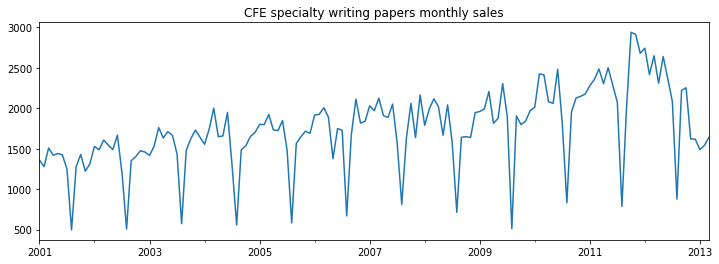

In [7]:
df.plot(figsize=(12,4))
plt.title("CFE specialty writing papers monthly sales")
plt.show()

**Коррелограмма**

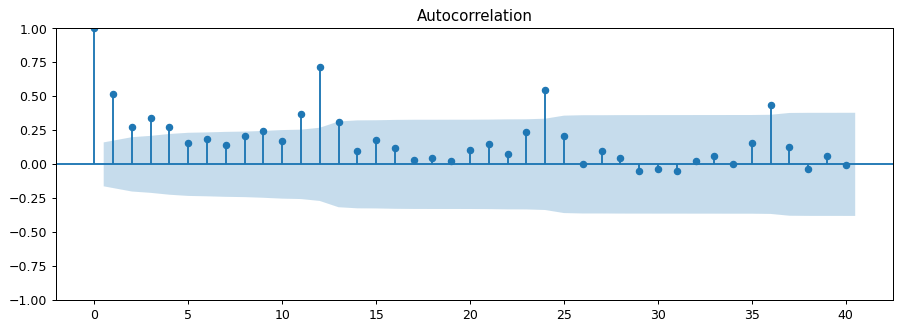

In [8]:
fig, ax = plt.subplots(figsize=(12,4), dpi=90)
plot_acf(df, lags=40, ax=ax)
plt.show()

### Выводы

Определённо есть сезонность каждые 12 месяцев, с трендом сложнее. Вроде бы явного тренда не наблюдается.

### Модели

Так как у нас есть сезонность, но нет тренда, то воспользуемся моделью Хольта-Уинтерса и просто в качестве аргумента `trend` зададим `None`.

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tools.eval_measures import mse

In [10]:
holt_winters = ExponentialSmoothing(df, initialization_method="estimated",
                                    trend=None, seasonal="add").fit()

In [11]:
holt_winters.model.params

{'smoothing_level': 0.54698580820104,
 'smoothing_trend': nan,
 'smoothing_seasonal': 0.11186444885891673,
 'damping_trend': nan,
 'initial_level': 1209.9873034712068,
 'initial_trend': nan,
 'initial_seasons': array([  123.92472567,   145.35231963,   292.63589286,   107.83454041,
           72.67325452,   195.9146449 ,  -176.52039441, -1034.98066712,
          -39.08587122,   116.16876862,    28.97562604,    81.90300751]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

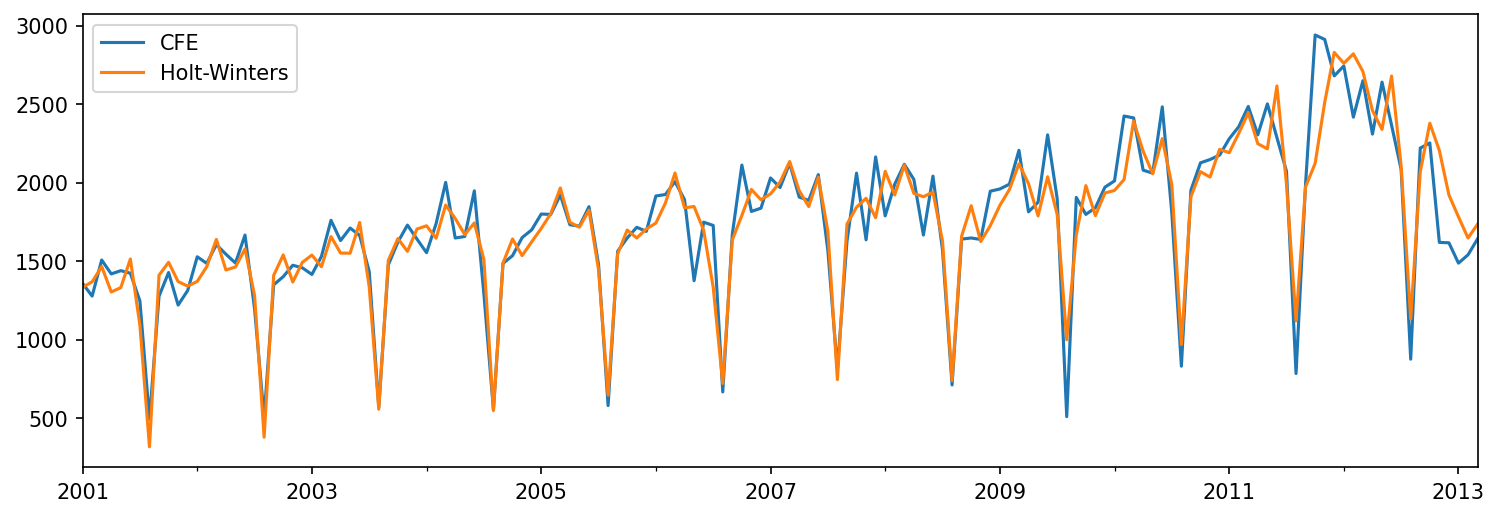

In [12]:
plt.figure(figsize=(12,4), dpi=150)
df.plot(label="CFE")
holt_winters.fittedvalues.plot(label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

**Среднеквадратичная ошибка**

In [13]:
mse(df, holt_winters.fittedvalues)

31711.93802756805

По графику можно видеть, что наша аппроксимация далека от идеальной и поэтому среднеквадратичная ошибка получилась достаточно большой, что плохо. 

### Прогноз

Построим прогноз на 3 года

In [14]:
start = df.index[-1] + pd.DateOffset(months=1)
end = start + pd.DateOffset(months=35)
start, end

(Timestamp('2013-04-01 00:00:00'), Timestamp('2016-03-01 00:00:00'))

In [15]:
holt_winters_forecast = holt_winters.predict(start=start, end=end)

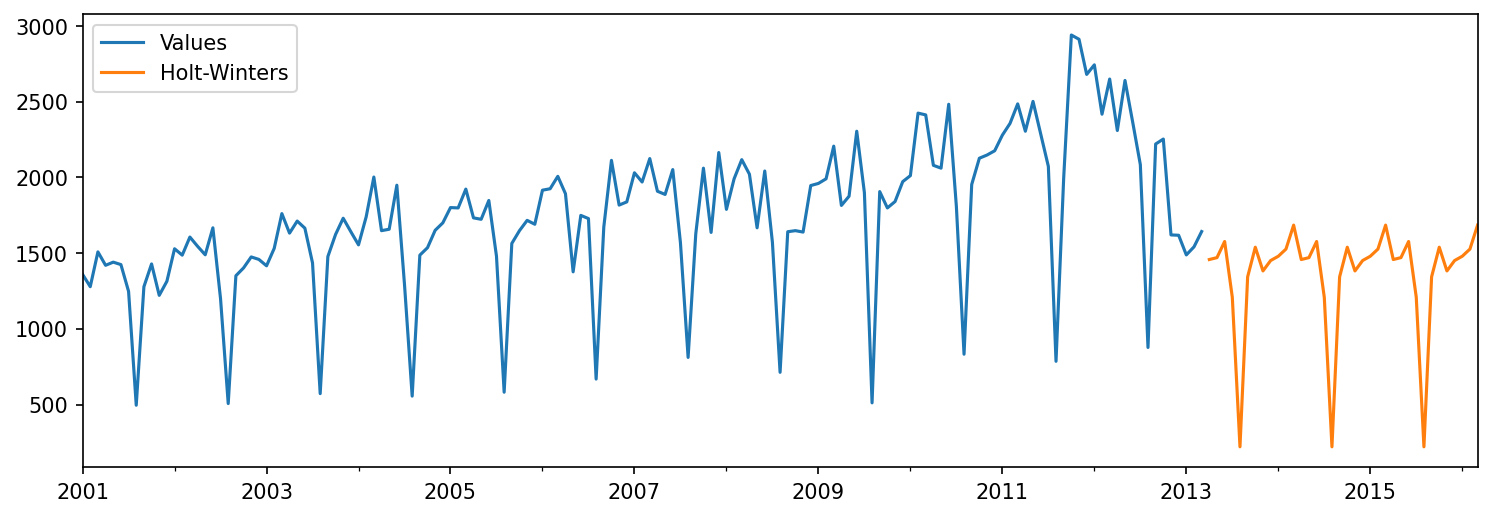

In [16]:
plt.figure(figsize=(12,4), dpi=150)
df.plot(label="Values")
holt_winters_forecast.plot(label="Holt-Winters")
plt.legend(loc="upper left")
plt.show()

Прогноз получился достаточно плохим.

К сожалению, я не понял какой моделью стоит воспользоваться, так как у нас есть сезонность, но нет тренда.

- Модель Брауна работает в случае когда у нас нет ни тренда, ни сезонности.
- Модель Хольта работает когда у нас есть только трендовая составляющая.
- Модель Хольта-Уинтерса работает когда у нас есть и тренд, и сезонность.

**НО** даже если рассматривать что у нас есть тренд, то результаты получаются не лучше.

In [17]:
holt_winters_trend = ExponentialSmoothing(df, initialization_method="estimated",
                                          trend="add", seasonal="add").fit()

In [18]:
holt_winters_trend.model.params

{'smoothing_level': 0.4977635340391571,
 'smoothing_trend': 0.0006995538540336418,
 'smoothing_seasonal': 0.17525221338364988,
 'damping_trend': nan,
 'initial_level': 1293.3327607213737,
 'initial_trend': 0.2546743139059798,
 'initial_seasons': array([  81.50235679,  139.50994768,  318.14570634,  130.27054666,
         127.12029905,  253.59828964, -156.36855214, -929.66752629,
         -68.46770417,   25.47287045,   36.58941771,   40.61629279]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

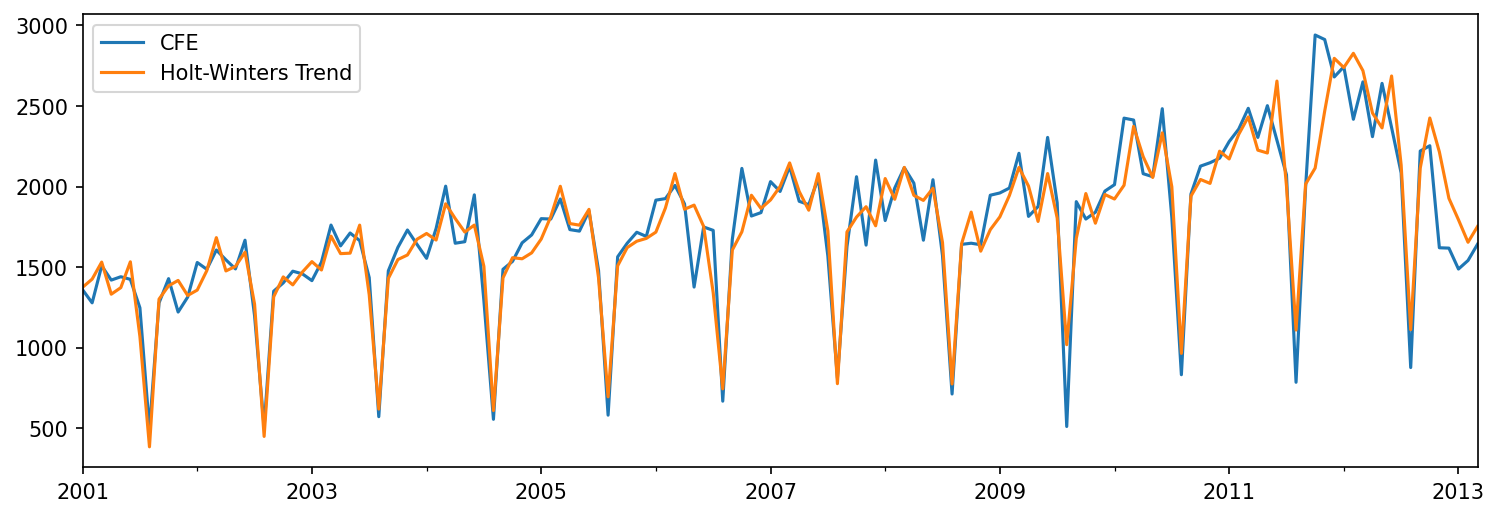

In [19]:
plt.figure(figsize=(12,4), dpi=150)
df.plot(label="CFE")
holt_winters_trend.fittedvalues.plot(label="Holt-Winters Trend")
plt.legend(loc="upper left")
plt.show()

**Среднеквадратичная ошибка**

In [20]:
mse(df, holt_winters_trend.fittedvalues)

32555.142003373054